--- NOTES ---

- 1 ns unit for time
- Convention: [qubit, resonator 1, resonator 2]

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import plots
from supports_1q_2c import *
from qutip import *
from scipy.special import erf
from scipy.signal import argrelextrema

pi = np.pi
exp = np.exp
sqrt = np.sqrt
hbar = 1.0546e-34*1e-9  # reduced Planck constant
All = 'all'
options = Options()

In [2]:
Nq = 3   # number of levels in qubit
N1 = 10  # number of levels in resonator 1
N2 = 10  # number of levels in resonator 2

wq = 7*2*pi  # qubit frequency
wp = wq  # pump frequency
w1 = wq  # resonator 1 frequency
w2 = wq  # resonator 2 frequency

kq = 50e-6*2*pi  # photon emission frequency of qubit (qubit decay rate)
k1 = 10e-6*2*pi  # photon emission freqency of resonator 1 (resonator 1 decay rate)
k2 = 8e-3*2*pi   # photon emission frequency of resonator 2 (resonator 2 decay rate)

g1 = 400e-6*2*pi  # drive frequency resonator 1, coupling between qubit and resonator 1
g2 = 3e-3*2*pi    # drive frequency resonator 2, coupling between qubit and resonator 2

chi1 = 30e-6*2*pi   # state-dependent frequency shift of resonator 1
chi2 = 500e-6*2*pi  # state-dependent frequency shift of resonator 2
delta = 0

Ec = 0.16*2*pi  # Anharmonicity

In [3]:
t0 = 0         # start Gaussian pulse Omega
t1 = t0 + 50   # end Gaussian pulse Omega
t2 = t1 + 10   # start square pulse at resonator 1
t3 = t2 + 100  # end square pulse at resonator 1
t4 = t3 + 10   # start square pulse at resonator 2
t5 = t4 + 168  # end square pulse at resonator 2
t6 = t5 + 10   # t0
tg = 10        # Gaussian rise and fall time of square pulse

N_repeat = 5  # number of times to repeat cycle
Np = int(t6)     # number of discrete time steps per cycle for which to store the output
Q = 3  # number of std's in Gaussian curves, rises and falls

In [4]:
# Qubit operators
b = tensor(destroy(Nq), qeye(N1), qeye(N2))
nq = b.dag()*b
sx = tensor(sigmax(), qeye(N1), qeye(N2)) # x-projection of qubit level
sy = tensor(sigmay(), qeye(N1), qeye(N2)) # y-projection of qubit level
sz = tensor(sigmaz(), qeye(N1), qeye(N2)) # z-projection of qubit level

# Cavity operators
a1 = tensor(qeye(Nq), destroy(N1), qeye(N2))
a2 = tensor(qeye(Nq), qeye(N1), destroy(N2))
n1 = a1.dag()*a1
n2 = a2.dag()*a2

# Jaynes-Cummings Hamiltonian
Hjc = ( (w1-wq)*(w1*a1.dag()*a1) - Ec/2*b.dag()*b.dag()*b*b 
      + chi1*nq*a1.dag()*a1 + chi2*nq*a2.dag()*a2 - delta*nq )
# not the measurement hamiltonian

# Coupling Hamiltonians
H1 = g1*(a1*b.dag() + b*a1.dag())
H2 = g2*(a2*b.dag() + b*a2.dag())

# Hamiltonian arguments
H_args = {"t0" : t0, "t1" : t1, "t2" : t2, "t3" : t3, 
          "t4" : t4, "t5" : t5, "t6" : t6, "tg" : tg,
          "g1" : g1, "g2" : g2, "Q"  : Q,  "Np" : Np,
          "N_repeat" : N_repeat}

# Pump Hamiltonian
Omega = 0.5*pump_strength(H_args)
H_args['Omega'] = Omega
Hp = Omega/2*(b + b.dag())  # including rotating frame

In [5]:
# Collapse operators, losses
cq = sqrt(kq)*b   # qubit
c1 = sqrt(k1)*a1  # resonator 1
c2 = sqrt(k2)*a2  # resonator 2
c_ops = [cq, c1, c2]

# Expectation operators
e_ops = [nq, n1, n2]

In [6]:
H = [Hjc, [Hp, pump], [H1, square1], [H2, square2]]  # complete Hamiltonian
tlist = np.linspace(0, N_repeat*t6, N_repeat*Np)  # discrete time steps for which to store the output
psi0 = tensor(basis(Nq,0), basis(N1,0), basis(N2,0))  # initial state

# Select these options for bdf method
# options.method = 'bdf'
# options.rtol = 1e-14

# Select these options for adams method
options.nsteps = 10000
options.rtol = 10e-9
options.max_step = 0.1

options.store_states=True

result = mesolve(H, psi0, tlist, c_ops, e_ops=e_ops, args=H_args, options=options)

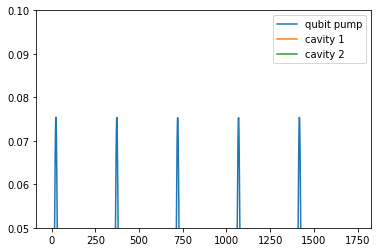

In [7]:
pump_pulse = Omega*pump(tlist, H_args)
sqr1_pulse = g1*square1(tlist, H_args)
sqr2_pulse = g2*square2(tlist, H_args)
plt.plot(tlist, pump_pulse, label='qubit pump')
plt.plot(tlist, sqr1_pulse, label='cavity 1')
plt.plot(tlist, sqr2_pulse, label='cavity 2')
plt.ylim([0.05,0.10])
plt.legend()

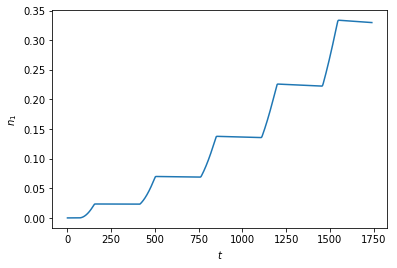

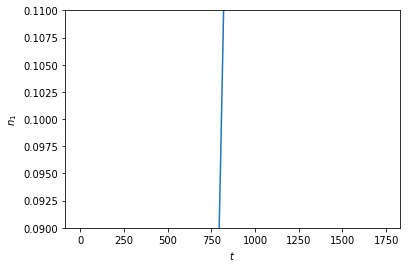

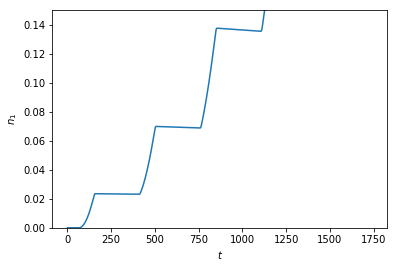

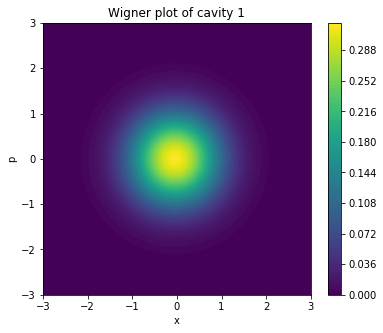

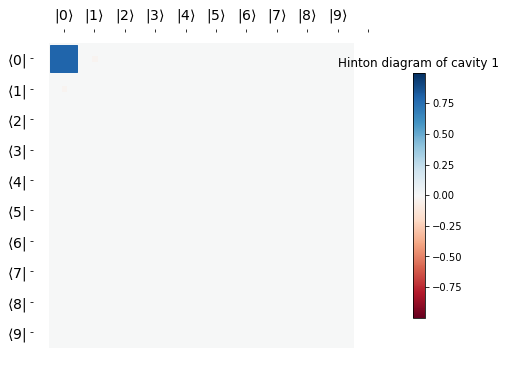

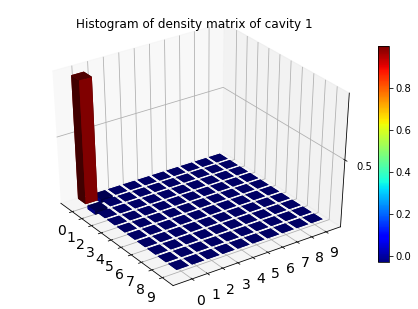

In [8]:
obj = 1    # 0 = qubit, 1 = cavity 1, 2 = cavity 2
ind = 90  # index of tlist

plt.figure()
plt.plot(tlist, result.expect[obj])
plt.xlabel("$t$")
plt.ylabel("$n_{}$".format(obj))

plt.figure()
plt.plot(tlist, result.expect[obj])
plt.xlabel("$t$")
plt.ylabel("$n_{}$".format(obj))
# plt.xlim([35,100])
plt.ylim([0.09,0.11])

plt.figure()
plt.plot(tlist, result.expect[obj])
plt.xlabel("$t$")
plt.ylabel("$n_{}$".format(obj))
# plt.xlim([t4,t5+40])
plt.ylim([0,0.15])

cont = plots.wigner(result.states, obj=obj, ind=ind)
plots.dmat_hinton(result.states, obj=obj, ind=ind)
plots.dmat_hist(result.states, obj=obj, ind=ind)